# Question A4

In this section, we will understand the utility of such a neural network in real world scenarios.

#### Please use the real record data named ‘record.wav’  as a test sample. Preprocess the data using the provided preprocessing script (data_preprocess.ipynb) and prepare the dataset.
Do a model prediction on the sample test dataset and obtain the predicted label using a threshold of 0.5. The model used is the optimized pretrained model using the selected optimal batch size and optimal number of neurons.
Find the most important features on the model prediction for the test sample using SHAP. Plot the local feature importance with a force plot and explain your observations.  (Refer to the documentation and these three useful references:
https://christophm.github.io/interpretable-ml-book/shap.html#examples-5,
https://towardsdatascience.com/deep-learning-model-interpretation-using-shap-a21786e91d16,  
https://medium.com/mlearning-ai/shap-force-plots-for-classification-d30be430e195)



1. Firstly, we import relevant libraries.

In [17]:
import tqdm
import time
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from scipy.io import wavfile as wav

from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
from common_utils import set_seed

# setting seed
set_seed()

To reduce repeated code, place your
network (MLP defined in QA1)
torch datasets (CustomDataset defined in QA1)
loss function (loss_fn defined in QA1)
in a separate file called common_utils.py

Import them into this file. You will not be repenalised for any error in QA1 here as the code in QA1 will not be remarked.

The following code cell will not be marked.


In [18]:
# YOUR CODE HERE
from common_utils import (
    MLP,
    CustomDataset,
    EarlyStopper,
    preprocess_dataset,
    intialise_loaders,
    split_dataset,
    preprocess_dataset,
)
loss_fn = nn.BCELoss()

2. Install and import shap

In [27]:
# YOUR CODE HERE
import shap

3. Read the csv data preprocessed from 'record.wav', using variable name 'df', and fill the size of 'df' in 'size_row' and 'size_column'.

In [20]:
df = pd.read_csv("new_record.csv")
size_row = df.shape[0]
size_column = df.shape[1]
# YOUR CODE HERE
df

,filename,tempo,total_beats,average_beats,chroma_stft_mean,chroma_stft_var,chroma_cq_mean,chroma_cq_var,chroma_cens_mean,chroma_cens_var,...,mfcc15_mean,mfcc15_var,mfcc16_mean,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var
0,record.wav,112.347147,51,25.5,0.480383,0.112182,0.579547,0.091646,0.268037,0.01149,...,-4.068466,46.232433,-4.134901,53.04004,-0.942354,35.105537,-3.529711,54.781456,-3.722849,53.242016


 4.  Preprocess to obtain the test data, save the test data as numpy array.

In [21]:
SEED = 0
def preprocess(X_train, df):
    """
    preprocess your dataset to obtain your test dataset, remember to remove the 'filename' as Q1
    """
    # YOUR CODE HERE
    standard_scaler = preprocessing.StandardScaler()
    standard_scaler.fit(X_train)
    X_test_scaled_eg = standard_scaler.transform(df)
    return X_test_scaled_eg

df1 = pd.read_csv('simplified.csv')
df1['label'] = df1['filename'].str.split('_').str[-2]

df = df.drop(columns='filename')

X_train, y_train, X_test, y_test = split_dataset(df1, ['label','filename'], 0.3, SEED)
X_test_scaled_eg = preprocess(X_train, df)
X_train_scaled, X_test_scaled = preprocess_dataset(X_train, X_test)

5. Do a model prediction on the sample test dataset and obtain the predicted label using a threshold of 0.5. The model used is the optimized pretrained model using the selected optimal batch size and optimal number of neurons. Note: Please define the variable of your final predicted label as 'pred_label'.

In [28]:
# YOUR CODE HERE
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader)
    train_loss, train_acc = 0, 0
    for X, y in dataloader:
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y.reshape(-1, 1))
        optimizer.zero_grad() # initialize gradient calculations
        loss.backward() # compute gradients
        optimizer.step() # execute one step of GD

        train_loss += loss.item()
        train_acc += (torch.sum(torch.eq(pred > 0.5, y.reshape(-1, 1))).item() / len(pred))

    train_loss /= size
    train_acc /= size
    return train_loss, train_acc

def test_loop(dataloader, model, loss_fn):
    size = len(dataloader)
    test_loss, test_acc = 0, 0
    model.eval()
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y.reshape(-1, 1)).item()
            test_acc += (torch.sum(torch.eq(pred > 0.5, y.reshape(-1, 1))).item() / len(pred))
    model.train()
    test_loss /= size
    test_acc /= size
    return test_loss, test_acc

BATCH_SIZE = 128
NUM_NEURONS = (256, 128, 128)

num_epochs = 100
lr = 0.001
no_features = 77
no_hidden = 3
no_labels = 1
early_stopping = 3

model = MLP(no_features, no_hidden, no_labels, no_hidden_neurons = NUM_NEURONS)
optimizer = torch.optim.Adam(model.parameters(), lr = lr)
loss_fn = nn.BCELoss()

train_dataloader, test_dataloader = intialise_loaders(X_train_scaled, y_train, X_test_scaled, y_test, batch_size = BATCH_SIZE)

train_loss_, train_acc_, test_loss_, test_acc_ = [], [], [], []
early_stopper = EarlyStopper(patience = early_stopping)

for epoch in tqdm.tqdm(range(num_epochs)):
    train_loss, train_acc = train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loss, test_acc = test_loop(test_dataloader, model, loss_fn)
    train_loss_.append(train_loss), train_acc_.append(train_acc)
    test_loss_.append(test_loss), test_acc_.append(test_acc)
    if early_stopper.early_stop(test_loss):
        break

print("Training accuracy:", train_acc_[-1])
print("Test accuracy:", test_acc_[-1])
with torch.no_grad():
    y = model(torch.tensor(X_test_scaled_eg, dtype=torch.float32))
    pred_label = 1 if y>=0.5 else 0
    print(pred_label)

Training accuracy: 0.7991369843391902
Test accuracy: 0.7003201064908722
1


6. Find the most important features on the model prediction for your test sample using SHAP. Create an instance of the DeepSHAP which is called DeepExplainer using traianing dataset: https://shap-lrjball.readthedocs.io/en/latest/generated/shap.DeepExplainer.html.

Plot the local feature importance with a force plot and explain your observations.  (Refer to the documentation and these three useful references:
https://christophm.github.io/interpretable-ml-book/shap.html#examples-5,
https://towardsdatascience.com/deep-learning-model-interpretation-using-shap-a21786e91d16,  
https://medium.com/mlearning-ai/shap-force-plots-for-classification-d30be430e195)


Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


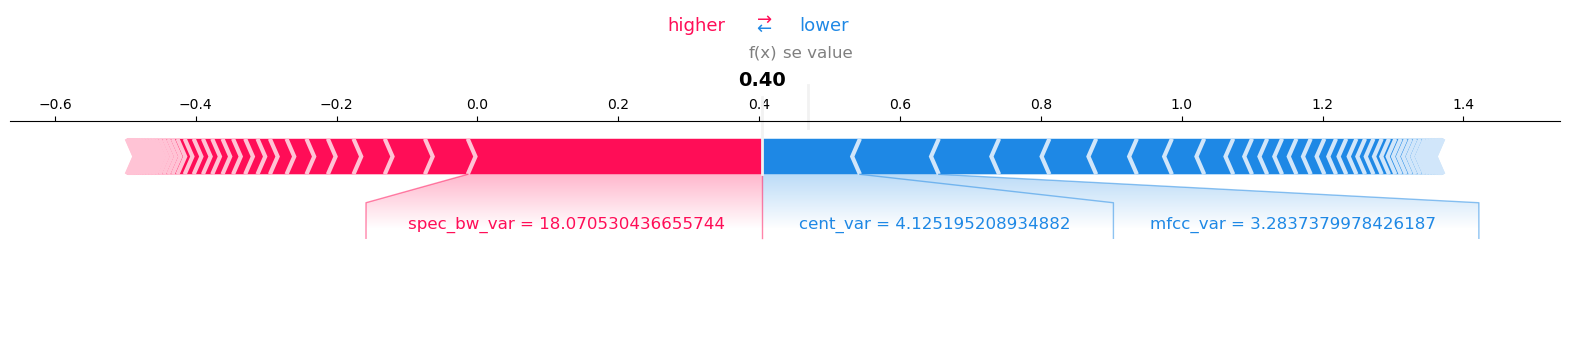

In [33]:
'''
Fit the explainer on a subset of the data (you can try all but then gets slower)
Return approximate SHAP values for the model applied to the data given by X.
Plot the local feature importance with a force plot and explain your observations.
'''
# YOUR CODE HERE
explainer = shap.DeepExplainer(model, torch.tensor(X_train_scaled, dtype=torch.float32))
shap_values = explainer.shap_values(torch.tensor(X_test_scaled_eg, dtype=torch.float32))
shap.force_plot(explainer.expected_value, shap_values, X_test_scaled_eg, feature_names=X_train.columns, matplotlib=True)

explanation = """
    From the force plot, we can see that the top 3 most important features are, in order:
    1. spec_bw_var
    2. cent_var
    3. mfcc_var
    This is based on the SHAP values displayed in the force plot.
"""

